In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
import cartopy
import cartopy.feature as cfeature

In [ ]:
%%html
<style>
    /* Jupyter */
    .rendered_html table,
    /* Jupyter Lab*/
    div[data-mime-type="text-markdown"] table {
        margin-left: 0
    }
</style>

In [ ]:
#Thèmes possibles: chesterish, grade3, ggruvboxd, gruvboxl, monokai, oceans16, onedork, solarizedd, solarizedl

!jt -t onedork

# Read MesoNH NetCDF files : read_MNHfile.py

One main function : read_netcdf

In [ ]:
def read_netcdf(LnameFiles, Dvar_input, path='.', get_data_only=True, del_empty_dim=True, removeHALO=True):
    """Read a netCDF4 Meso-NH file
    For each file, call functions to read diachronic or synchronous file
    
    Parameters
    ----------
    LnameFiles : list of str
        list of Meso-NH netCDF4 file (diachronic or synchronous)
    
    Dvar_input : Dict{'keyFile' : 'var_name',('group_name','var_name')}
        where
        'keyFile' is a str corresponding to a key for the file number in LnameFiles (by order)
        'var_name' is the exact str of the netCDF4 variable name
        ('group_name','var_name') is the exact tuple of the (sub-)groups name and the netCDF4 variable name
        e.g. : {'f1':['ZS', 'WT','ni', 'level'],
                'f2':[('/LES_budgets/Cartesian/Not_time_averaged/Not_normalized/cart/',MEAN_TH'),('/Budgets/RI','AVEF')]
                }
    
    path : str
        unique path of the files
    
    get_data_only : bool, default: True
        if True,  the function returns Dvar as masked_array (only data)
        if False, the function returns Dvar as netCDF4._netCDF4.Variable
    
    del_empty_dim : bool, default: True
        if get_data_only=True and del_empty_dim=True, returns Dvar as an array without dimensions with size 1 and 0
        e.g. : an array of dimensions (time_budget, cart_level, cart_nj, cart_ni) with shape (180,1,50,1) is returned (180,50)
        
    removeHALO : bool, default: True
        if True, remove first and last (NHALO=1) point [1:-1] if get_data_only=True on each 
        level, level_w, ni, ni_u, ni_v, nj, nj_u, nj_v dimensions
           
    Returns
    -------
    Dvar : Dict 
        Dvar[ifile]['var_name']                if the group contains only one variable
        Dvar[ifile][('group_name','var_name')] if the group contains more than one variable
    """

## Synchronous file

### Example : one file (KTEST 012_dust)

In [ ]:
from read_MNHfile import read_netcdf

LnameFiles = list of name of files (here one)

In [ ]:
#  List of Meso-NH files present in the path
path="/home/rodierq/TP_PYTHON/"
LnameFiles = ['DUST7.1.SEG01.004.nc']

Dvar_input = Dict{'keyFile' : [list of variables name] }

In [ ]:
Dvar_input = {'f1':['ZS', 'UT','VT', 'WT','THT',
      'DSTM03T','DSTM33T','DSTM02T','DSTM32T','DSTM01T','DSTM31T','F_DST001P1','F_DST002P1','F_DST003P1',
      'latitude','longitude','level',
      'INPRR','ACPRR','PABST','RCT','RVT','RRT','LSTHM']}


Call of the function :

In [ ]:
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path)

In [ ]:
Dvar.keys()

In [ ]:
Dvar['f1'].keys()

In [ ]:
type(Dvar['f1']['THT'])

#### get_data_only=False
returns netCDF4._netCDF4.Variable

In [ ]:
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, get_data_only=False)

In [ ]:
type(Dvar['f1']['THT'])

In [ ]:
Dvar['f1']['THT']

#### del_empty_dim=True
remove the useless dimensions (size = 1) with get_data_only=True

#### removeHALO=True
remove the non-physical extra points (HALO) of all variables and dimensions (with get_data_only=True for now)

In [ ]:
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, get_data_only=True, del_empty_dim=True, removeHALO=True)

In [ ]:
Dvar['f1']['THT'].shape

### Example : multiple synchronous files (KTEST 001_2Drelief)

In [ ]:
LnameFiles = ['EXPER.1.HYD2D.001.nc', 'EXPER.1.HYD2D.002.nc']
Lvariables = ['ZS', 'UT', 'WT', 'THT', 'RVT','LSUM','LSTHM','CFLU','CFLW','ni_u','level','ZTOP', 'ni','level_w','time']
Dvar_input = {'f1':Lvariables,'f2':Lvariables}

#  Read the variables in the files
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, get_data_only=False)

In [ ]:
Dvar.keys()

In [ ]:
Dvar['f2'].keys()

In [ ]:
Dvar['f2']['UT']

### Example : different variables between files (KTEST 003_KW78)

In [ ]:
LnameFiles = ['KWRAI.1.SEG01.004.nc','KWRAI.1.SEG01.004dia.nc' ]
Dvar_input = {
'f1':['ZS', 'UT','VT', 'WT','THT',
      'ni_u','nj_u','level','ZTOP', 'ni','nj','level_w','time',
      'INPRR','ACPRR','PABST','RCT','RVT','RRT','LSTHM'],
'f2':['ALT_CLOUD', 'ALT_U', 'ALT_V', 'ni','nj']}

#  Read the variables in the files
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=True)

## Time-series file

### Example : one file (KTEST 005_ARM)

In [ ]:
LnameFiles = ['ARM__.1.CEN4T.000.nc' ]
LG_MEAN = '/LES_budgets/Mean/Cartesian/Not_time_averaged/Not_normalized/cart/'
LG_SBG = '/LES_budgets/Subgrid/Cartesian/Not_time_averaged/Not_normalized/cart/'

Dvar_input = {
'f1':[(LG_MEAN,'MEAN_TH') , (LG_MEAN,'MEAN_U')  , (LG_MEAN,'MEAN_V') , (LG_MEAN,'MEAN_RC'), (LG_MEAN,'MEAN_RR'),
      (LG_SBG,'SBG_TKE') , (LG_SBG,'SBG_WTHL'), (LG_SBG,'SBG_WRT'), (LG_SBG,'THLUP_MF'), (LG_SBG,'RTUP_MF') , 
      (LG_SBG,'RVUP_MF'), (LG_SBG,'RCUP_MF'), (LG_SBG,'RIUP_MF'), (LG_SBG,'WUP_MF'), (LG_SBG,'MAFLX_MF'), 
      (LG_SBG,'DETR_MF') , (LG_SBG,'ENTR_MF'), (LG_SBG,'FRCUP_MF'), (LG_SBG,'THVUP_MF'), (LG_SBG,'WTHL_MF'),
      (LG_SBG,'WRT_MF')  , (LG_SBG,'WTHV_MF') , (LG_SBG,'WU_MF')  , (LG_SBG,'WV_MF'),
      'level_les','time_les']
}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=False, get_data_only=True)

In [ ]:
Dvar['f1'].keys()

In [ ]:
Dvar['f1'][(LG_SBG,'SBG_WRT')]

### Example : synchronous and time-series file (KTEST AZF_2M)

In [ ]:
LnameFiles = ['AZF02.1.CEN4T.001.nc', 'AZF02.1.CEN4T.002.nc', 'AZF02.1.CEN4T.003.nc',
              'AZF02.1.CEN4T.004.nc', 'AZF02.1.CEN4T.005.nc', 'AZF02.1.CEN4T.007.nc',
              'AZF02.2.CEN4T.001.nc', 'AZF02.2.CEN4T.002.nc', 'AZF02.2.CEN4T.003.nc',
              'AZF02.2.CEN4T.004.nc', 'AZF02.2.CEN4T.005.nc', 'AZF02.2.CEN4T.007.nc',
              'AZF02.1.CEN4T.000.nc']
# Or mor pythonic : 
# LnameFiles = ['AZF02.'+str(nmodel)+'.CEN4T.00'+str(x)+'.nc' for x in to7 for nmodel in range(1,3)]
# LnameFiles.append('AZF02.1.CEN4T.000.nc')

LG_AVION='/Flyers/Aircrafts/AVION/'
LG_AVIONT='/Flyers/Aircrafts/AVION/Point/'
LG_AVIONZT='/Flyers/Aircrafts/AVION/Vertical_profile/'

Lvariables=['SVT001','SVT002','ATC001','ATC002','UT','VT','latitude','longitude','level']

Dvar_input = {'f1':Lvariables,
'f2':Lvariables,
'f3':Lvariables,
'f4':Lvariables,
'f5':Lvariables,
'f6':Lvariables,
'f7':Lvariables+['LONOR','LATOR','LAT','LON'],
'f8':Lvariables,
'f9':Lvariables,
'f10':Lvariables,
'f11':Lvariables,
'f12':Lvariables,
'f13':[(LG_AVION,'time_flyer'),(LG_AVIONT,'ZS'), (LG_AVIONT,'P'), (LG_AVIONT,'LON'),(LG_AVIONT,'MER_WIND'),
       (LG_AVIONT,'ZON_WIND'),(LG_AVIONT,'W'), (LG_AVIONT,'Th'), (LG_AVIONT,'Rv'),(LG_AVIONT,'Tke'),
       (LG_AVIONT,'H_FLUX'),(LG_AVIONT,'LE_FLUX'), (LG_AVIONT,'Tke_Diss'), (LG_AVIONT,'Tsrad')]
}

#  Read the variables in the files
DvarAZF = read_netcdf(LnameFiles, Dvar_input, path=path)

In [ ]:
DvarAZF.keys()

In [ ]:
DvarAZF['f13'].keys()


# Plot figures : Panel_Plot.py

class PanelPlot handles general main features of the Panel

In [ ]:
class PanelPlot():
    
    def __init__(self, nb_l, nb_c, Lfigsize, bigtitle, titlepad=40, minmaxpad=1.03, timepad=-0.06, lateralminmaxpad=0.86, 
                 labelcolorbarpad=6.0, colorbaraspect=20, colorbarpad=0.04, tickspad=0.8,
                 minmaxTextSize=10, bigtitleSize=13, titleSize=12, legendSize=10,
                 xlabelSize=11, ylabelSize=11, timeSize=11, cbTicksLabelSize=11, cbTitleSize=11, xyTicksLabelSize=10, figBoxLinewidth=1,
                 xyTicksWidth=1, xyTicksLength=6):

        self.bigtitle = bigtitle       #  Panel title
        self.Lfigsize = Lfigsize       #  Panel size
        self.nb_l = nb_l               #  Panel number of lines
        self.nb_c = nb_c               #  Panel number of rows
        self.nb_graph = 0              #  New independent graph within the subplot

        self.titlepad = titlepad       #  Title pad (vertical shift) from graph
        self.tickspad = tickspad       #  Ticks pad (between ticks and axis label)
        self.minmaxpad = minmaxpad     #  Min/Max print pad (vertical shift)
        self.timepad = timepad         #  Time print pad (vertical shift)
        self.colorbarpad = colorbarpad #  Colorbar pad (horizontal shift from graph)
        self.lateralminmaxpad = lateralminmaxpad
        self.labelcolorbarpad = labelcolorbarpad #  Vertical colorbal label pad
        self.colorbaraspect = colorbaraspect     #  Ratio of long to short dimensions of colorbar w.r.t. the figure
        
        self.minmaxTextSize = minmaxTextSize     #  min/max text fontsize
        self.bigtitleSize = bigtitleSize         #  Panel title fontsize
        self.titleSize = titleSize               #  Graph title fontsize
        self.xlabelSize = xlabelSize             #  X-label fontsize
        self.ylabelSize = ylabelSize             #  Y-label fontsize
        self.legendSize = legendSize             #  X/Y plot legend fontsize
        self.timeSize = timeSize                 #  Time attribute of the graphs fontsize
        self.cbTicksLabelSize = cbTicksLabelSize #  Colorbar ticks label fontsize
        self.cbTitleSize = cbTitleSize           #  Colorbar title fontsize
        self.xyTicksLabelSize = xyTicksLabelSize #  X/Y ticks label fontsize
        self.figBoxLinewidth = figBoxLinewidth   #  Figure Box contour line width

        self.xyTicksWidth = xyTicksWidth   #  Ticks width
        self.xyTicksLength = xyTicksLength #  Ticks length 

        #  Initialization of the panel plots
        self.fig = plt.figure(figsize=(self.Lfigsize[0],self.Lfigsize[1]))
        self.fig.set_dpi(125)
        self.fig.suptitle(self.bigtitle,fontsize=bigtitleSize)

In [ ]:
Panel1 = PanelPlot(2,2, [5,5],'Empty figure')
Panel1.fig.show()

In [ ]:
type(Panel1.fig)

Not-drawing functions of PanelPlot

* save_graph()            
Create a temporary png file of the panel plot which can be converted to PDF
* draw_Backmap()          
Handle drawing of the background plot (coastlines, departements, grid lines and labels)
* addWhitecm()            
Add a white color at the top or bottom of the colormap depending of colors used
* set_Title()             
Handle top title of each graph
* set_x/ylim()            
Handle x/y limits plotted of each graph
* set_XYaxislab()         
Handle x and y axis labels
* addLine()               
Draw a straitght line with (x,y) coordinates of begin/end point
* set_minmaxText()        
Show min and max values Text in the plot
* showTimeText()          
Show time validity

Usage examples will follow with drawing functions examples

Drawing functions of PanelPlot
* pXY_lines()
* psectionV()
* psectionH()
* pvector()
* pXY_bar()
* pstreamline()

## X/Y lines

In [ ]:
    def pXY_lines(self, Lxx=[], Lyy=[], Lxlab=[], Lylab=[], Ltitle=[], Llinetype=[], Llinewidth=[],
                 Llinecolor=[], Llinelabel=[], LfacconvX=[], LfacconvY=[], ax=[], id_overlap=None, Lxlim=[], 
                 Lylim=[], Ltime=[], LaxisColor=[]):
      """
        XY (multiple)-lines plot
        Parameters :
            - Lxx    : List of variables to plot or coordinates along the X axis
            - Lyy    : List of variables to plot or coordinates along the Y axis
            - Lxlab  : List of x-axis label
            - Lylab  : List of y-axis label
            - Lxlim  : List of x (min, max) value plotted
            - Lylim  : List of y (min, max) value plotted
            - Ltime  : List of time (validity)
            - Ltitle : List of sub-title
            - Llinewidth : List of lines thickness
            - Llinetype  : List of line types
            - Lcolorlines: List of color lines
            - Llinelabel : List of legend label lines
            - LfacconvX/Y: List of factors for unit conversion of the variables/coordinates to plot on X and Y axis
            - ax         : List of fig.axes for ploting multiple different types of plots in a subplot panel
            - Lid_overlap: List of number index of plot to overlap current variables
            - LaxisColor : List of colors for multiple x-axis overlap
      """

### Single line, time-series : KTEST AZF_2M

In [ ]:
%matplotlib notebook
from read_MNHfile import read_netcdf
from Panel_Plot import PanelPlot

Panel = PanelPlot(8,2, [10,16],'Time series from Aircraft', titlepad=30, minmaxpad=1.04, timepad=-0.07, colorbarpad=0.03, 
                  labelcolorbarpad = 13, colorbaraspect=18,xlabelSize=9, ylabelSize=9, titleSize=9)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'ZS')]]
Ltime = [DvarAZF['f13'][(LG_AVION,'time_flyer')]/3600.0]
Ltitle = ['Orography']
Lxlab = ['Time (h)']
Lylab = ['ZS (m)']
Lylim = [(0, 350)]
Lxlim = [(9.0, 9.2)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim)
fig.show()

In [ ]:
Lplot = [ DvarAZF['f13'][(LG_AVIONT,'P')]]
Ltitle = ['Pressure']
Lylab = ['P (Pa)']
Lylim = [(0, 95000)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes) 

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'LON')]]
Ltitle = ['Longitude']
Lylab = ['Longitude']
Lylim = [(0, 2.5)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'ZON_WIND')]]
Ltitle = ['Zonal wind']
Lylab = ['u (m/s)']
Lylim = [(-1, 11)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'MER_WIND')]]
Ltitle = ['Meridional wind']
Lylab = ['v (m/s)']
Lylim = [(-3, 3)]
Llinelabel=['V']
fig = Panel.pXY_lines(Llinelabel=Llinelabel, Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'W')]]
Ltitle = ['Vertical velocity']
Lylab = ['w (m/s)']
Lylim = [(-0.1, 0.1)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'Th')]]
Ltitle = ['Potential Temperature']
Lylab = [r'$\theta$ (K)']
Lylim = [(290, 305)]
fig = Panel.pXY_lines(Llinecolor=['red'],Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'Rv')]]
Ltitle = ['Water vapor mixing ratio']
Lylab = ['Rv (kg/kg))']
Lylim = [(0, 0.01)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'Tke')]]
Ltitle = ['Turbulent Kinetic Energy']
Lylab = ['TKE ($m^2s^{-2}$)']
Lylim = [(0, 0.1)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'Tke_Diss')]]
Ltitle = ['Turbulent Kinetic Energy Dissipation']
Lylab = ['TKE Diss ($m^2s^{-2}$']
Lylim = [(0, 1000)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'H_FLUX')]]
Ltitle = ['Sensible Heat Flux H']
Lylab = ['H ($W/m^2$)']
Lylim = [(-0.7, 0.)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'LE_FLUX')]]
Ltitle = ['Latent Heat Flux LE']
Lylab = ['LE ($W/m^2$)']
Lylim = [(0, 2.0)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

Lplot = [ DvarAZF['f13'][(LG_AVIONT,'Tsrad')]]
Ltitle = ['Radiative surface temperature']
Lylab = ['Tsrad (K))']
Lylim = [(250, 1000)]
fig = Panel.pXY_lines(Lyy=Lplot, Lxx=Ltime, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, ax=fig.axes)

fig.tight_layout()
Panel.save_graph(7,fig)
Panel.fig.show()

### Multiple lines 1D profiles : KTEST COPT81

In [ ]:
from read_MNHfile import read_netcdf
from Panel_Plot import PanelPlot

LnameFiles = ['COPT8.1.CEN4T.000.nc' ]
Dvar_input = {'f1':[ ('/Budgets/TH','DEPS'),('/Budgets/TH','SFR'),('/Budgets/TH','IMLT'),('/Budgets/TH','DEPG'),('/Budgets/TH','REVA'),('/Budgets/TH','SFR'),
                     ('/Budgets/TH','DRYG'),('/Budgets/TH','WETG'),('/Budgets/TH','DEPI'),('/Budgets/TH','GMLT'),('/Budgets/TH','RIM'),('/Budgets/TH','BERFI'),
                     ('/Budgets/TH','CFRZ'),('/Budgets/TH','ACC'),
                     'time_budget','mask_level']}

#  Read the variables in the files
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path)

In [ ]:
Panel = PanelPlot(2,2, [10,10],'COPT81 avec Mask', titlepad=11, minmaxpad=1.04, timepad=-0.07, colorbarpad=0.03, 
                  labelcolorbarpad = 13, colorbaraspect=40, legendSize=6, xyTicksLabelSize=8, titleSize=9)

# Budget of potential temperature
nmask=0 #Convective mask, criteria in set_mask.f90
ntime=7 # 8th hour

Lplot = [Dvar['f1'][('/Budgets/TH','SFR')][nmask,ntime,:],  Dvar['f1'][('/Budgets/TH','DEPS')][nmask,ntime,:], 
         Dvar['f1'][('/Budgets/TH','DEPG')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','REVA')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','DEPI')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','IMLT')][nmask,ntime,:], 
         Dvar['f1'][('/Budgets/TH','GMLT')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','DRYG')][nmask,ntime,:], 
         Dvar['f1'][('/Budgets/TH','ACC')][nmask,ntime,:],  Dvar['f1'][('/Budgets/TH','RIM')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','BERFI')][nmask,ntime,:],Dvar['f1'][('/Budgets/TH','CFRZ')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','WETG')][nmask,ntime,:]]

LaxeZ = [Dvar['f1']['mask_level']]*len(Lplot)
Ltitle = ['Bilan température potentielle : partie convective - MASK1']*len(Lplot)
Llinelabel = ['SFR','DEPS','DEPG','REVA','DEPI','IMLT','GMLT','DRYG','ACC','RIM','BERFI','CFRZ','WETG']
Lxlim = [(-0.7E-2, 0.7E-2)]*len(Lplot)
Lxlab = ['Terme du bilan (K)']*len(Lplot)
Lylab = ['altitude (m)']*len(Lplot)
Lylim = [(0,12000.0)]*len(Lplot)
LaxisColor = ['black']*len(Lplot)
Llinewidth = [3]*len(Lplot)
LfacconvX=[1]*len(Lplot)
Llinecolor = ['red','green','blue','cyan','indigo','bisque','brown','orange','yellow',
              'magenta','gray','lightblue','black']

fig = Panel.pXY_lines(Lxx=Lplot, Lyy=LaxeZ, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Llinewidth=Llinewidth, LfacconvX=LfacconvX,
                        Lylim=Lylim, Lxlim=Lxlim, Llinelabel=Llinelabel, Llinecolor=Llinecolor,LaxisColor=LaxisColor)

fig.show()

In [ ]:
fig.axes[0].legend(loc='upper left', fontsize=9)

In [ ]:
nmask=1 #Convective mask, criteria in set_mask.f90
Lplot = [Dvar['f1'][('/Budgets/TH','SFR')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','DEPS')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','DEPG')][nmask,ntime,:],Dvar['f1'][('/Budgets/TH','REVA')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','DEPI')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','IMLT')][nmask,ntime,:], 
         Dvar['f1'][('/Budgets/TH','GMLT')][nmask,ntime,:],Dvar['f1'][('/Budgets/TH','DRYG')][nmask,ntime,:], 
         Dvar['f1'][('/Budgets/TH','ACC')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','RIM')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','BERFI')][nmask,ntime,:], Dvar['f1'][('/Budgets/TH','CFRZ')][nmask,ntime,:],
         Dvar['f1'][('/Budgets/TH','WETG')][nmask,ntime,:]]

Lxlim = [(-0.7E-3, 0.7E-3)]*len(Lplot)
Ltitle = ['Bilan température potentielle : partie stratiforme - MASK2']*len(Lplot)

fig = Panel.pXY_lines(Lxx=Lplot, Lyy=LaxeZ, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Llinewidth=Llinewidth, LfacconvX=LfacconvX,
                        Lylim=Lylim, Lxlim=Lxlim, Llinelabel=Llinelabel, Llinecolor=Llinecolor,LaxisColor=LaxisColor,
                        ax=fig.axes)
fig.axes[1].legend(loc='upper left', fontsize=9)
Panel.fig.show()

### Overlapping plots, multi x-axe 1D profiles : KTEST 001_2DRelief
overlapping is set with 
* ax = the axis on which draw the new ax
* id_overlap = the axis number on which draw the new ax (from the call of PanelPlot)

In [ ]:
from misc_functions import comp_altitude1DVar
import copy

LnameFiles = ['EXPER.1.HYD2D.002.nc']
Dvar_input = {'f1':['ZS', 'UT', 'WT', 'THT', 'RVT','LSUM','LSTHM','CFLU','CFLW','ni_u','level','ZTOP', 'ni','level_w','time']}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=True)

Dvar['f1']['altitude'], Dvar['f1']['ni_u_2D'] = comp_altitude1DVar(Dvar['f1']['UT'], Dvar['f1']['ZS'],Dvar['f1']['ZTOP'], Dvar['f1']['level'],Dvar['f1']['ni_u'])
Dvar['f1']['THT-LSTHM'] = copy.deepcopy(Dvar['f1']['THT'])
Dvar['f1']['THT-LSTHM'] = Dvar['f1']['THT'] - Dvar['f1']['LSTHM']

Panel6 = PanelPlot(1,1, [6,6],'')

Lplot = [ Dvar['f1']['WT'][:,127]]
LaxeZ = [Dvar['f1']['altitude'][:,127]]*len(Lplot)
Ltitle = ['WT and THT-LSTHM']*len(Lplot)
Llinelabel = ['WT']
Lxlab = ['velocity (m/s)']*len(Lplot)
Lylab = ['altitude (m)']*len(Lplot)
Lylim = [(0,15000.1)]*len(Lplot)
Lxlim = [(-0.3,0.3)]
Llinecolor = ['r']
LaxisColor = Llinecolor
Ltime = [Dvar['f1']['time']]
fig6 = Panel6.pXY_lines(Lyy=LaxeZ, Lxx=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lylim=Lylim, Lxlim=Lxlim, Llinelabel=Llinelabel, 
                                Llinecolor=Llinecolor, LaxisColor=LaxisColor, Ltime=Ltime)

Lplot = [ Dvar['f1']['THT-LSTHM'][:,127]]
Ltitle = []
Lylab = ['']
Llinelabel = ['THT - LSTHM ']
Lxlab = ['theta perturb (K)']*len(Lplot)
Lylim = [(0,15000.1)]*len(Lplot)
Lxlim = [(-0.8,0.1)]
Llinecolor = ['g']
LaxisColor = Llinecolor
fig7 = Panel6.pXY_lines(Lyy=LaxeZ, Lxx=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle,ax=fig6.axes, id_overlap=1, 
                        Lylim=Lylim, Lxlim=Lxlim, Llinelabel=Llinelabel, Llinecolor=Llinecolor,LaxisColor=LaxisColor, Ltime=Ltime)
fig7.show()

In [ ]:
def comp_altitude1DVar(oneVar2D, orography, ztop, level, n_xory):
    """Returns the altitude and x or y grid mesh variable in 2D following the topography in 1D
    To be used with 2D simulations
    
    Parameters
    ----------
    oneVar2D : array 2D
        a 2D array (e.g. UT, THT)
        
    orography : array 1D
        1D orography (ZS)
        
    ztop : real
        scalar of the top height of the model (ZTOP)
        
    level : array 1D
        1D level variable (level or level_w)
        
    n_xory : array 1D  
        1D directionnal grid variable (ni_u, nj_u, ni_v or nj_v)
        
    Returns
    -------
    altitude
        a 2D altitude variable with topography taken into account
        
    n_xory_2D
        a 2D directionnal variable duplicated from n_xory
    """

In [ ]:
Dvar['f1']['ZS'][127]

In [ ]:
Dvar['f1']['level']

In [ ]:
Dvar['f1']['altitude'][:,127]

## Horizontal sections

In [ ]:
    def psectionH(self, lon=[],lat=[], Lvar=[], Lcarte=[], Llevel=[], Lxlab=[], Lylab=[], Ltitle=[], Lminval=[], Lmaxval=[], 
                 Lstep=[], Lstepticks=[], Lcolormap=[], LcolorLine=[], Lcbarlabel=[], Lproj=[], Lfacconv=[], coastLines=True, ax=[], 
                 Lid_overlap=[], colorbar=True, Ltime=[], LaddWhite_cm=[], LwhiteTop=[], Lpltype=[], Lcbformatlabel=[]):
      """
        Horizontal cross section plot
        Parameters :
        --> - lon    : longitude 2D array
        --> - lat    : latitude 2D array
        --> - Lvar   : List of variables to plot
        --> - Lcarte : Zooming [lonmin, lonmax, latmin, latmax]
        --> - Llevel : List of k-level value for the section plot (ignored if variable is already 2D)
            - Lxlab  : List of x-axis label
            - Lylab  : List of y-axis label
            - Ltitle : List of sub-title
            - Ltime  : List of time (validity)
        --> - Lminval: List of minimum value for each colorbar/contours
        --> - Lmaxval: List of maximum value for each colorbar/contours
        --> - Lstep  : List of color-steps for each colorbar
        --> - Lstepticks : List of value of labels for each colorbar
        --> - Lcolormap  : List of colormap
            - LcolorLine : List of colors for colors arg of contour (color line only)
        --> - Lcbarlabel : List of colorbar label legend (units)
        --> - Lproj      : List of ccrs cartopy projection ([] for cartesian coordinates)
            - Lfacconv   : List of factors for unit conversion of each variables
        --> - coastLines : Boolean to plot coast lines and grid lines
            - ax         : List of fig.axes for ploting multiple different types of plots in a subplot panel
            - Lid_overlap : List of number index of plot to overlap current variables
        --> - colorbar   : show colorbar or not
        --> - Lpltype      : List of types of plot 'cf' or 'c'. cf=contourf, c=contour (lines only)
        --> - LaddWhite_cm : List of boolean to add white color to a colormap at the first (low value) tick colorbar
        --> - LwhiteTop    : List of boolean to add the white color at the first top (high value). If false, the white is added at the bottom if Laddwhite_cm=T            
        --> - Lcbformatlabel: List of boolean to reduce the format to exponential 1.1E+02 format colorbar label
      """    

### Conformal coordinate with coastal/regions line and grid iso-contours : KTEST 009_ICARTT

The projection is handled by the cartopy python package (https://scitools.org.uk/cartopy/docs/latest/)
All projections available are described here https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections

In [ ]:
import cartopy.crs as ccrs
from Panel_Plot import PanelPlot

LnameFiles = ['ICART.1.SEG01.001dg.nc']
Dvar_input = {
'f1':['MRC','COT','O3T','O3_PROD','O3_LOSS','CO_PROD','CO_LOSS','level','ZTOP', 'longitude','latitude','level_w','time',
      'CO_BUDGET','O3_BUDGET','O3_CHREACLIST','CO_CHREACLIST']}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=True)

###############################################################
Panel1 = PanelPlot(3,2, [14,17],'Horizontal section at 1150m, 19h', titlepad=25, minmaxpad=1.04, timepad=-0.07, 
                   colorbarpad=0.01, colorbaraspect=23, labelcolorbarpad=13)

Lplot = [ Dvar['f1']['MRC'][:,:,:], Dvar['f1']['COT'][:,:,:] , Dvar['f1']['O3_PROD'][:,:,:],
         Dvar['f1']['O3_LOSS'][:,:,:], Dvar['f1']['CO_LOSS'][:,:,:]]

LaxeX = [Dvar['f1']['longitude']]*len(Lplot)
LaxeY = [Dvar['f1']['latitude']]*len(Lplot)
Ltitle = ['Cloud mixing ratio', 'Carbon monoxyde CO ', 'Ozone production', 'Ozone destruction',
          'Carbon monoxyde destruction']
Lcbarlabel = ['g/kg', 'ppbv','ppbv/h','ppbv/h','ppbv/h']
Lylab = ['latitude','','latitude','','latitude']
Lxlab = ['longitude']*len(Lplot)
Lminval = [ 0, 107.5, 70, 70, 0.5 ]
Lmaxval = [ 0.2, 137.5, 130, 130, 1.7 ]
Lstep = [ 0.01, 2.5, 5, 5, 0.1]
Lstepticks = Lstep
Lfacconv = [ 1, 1, 1e9*3600, 1e9*3600, 1e9*3600]
Lcolormap = ['gist_ncar']*len(Lplot)
Llvl = [14]*len(Lplot)
LaddWhite_cm = [True, False, False, False, False]
Lprojection = [ccrs.PlateCarree()]*len(Lplot)

fig1 = Panel1.psectionH(lon=LaxeX, lat=LaxeY, Lvar=Lplot, Llevel=Llvl,Lylab=Lylab, Lxlab=Lxlab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, 
                                Lstep=Lstep, Lstepticks=Lstepticks, Lcolormap=Lcolormap, Lcbarlabel=Lcbarlabel, Lfacconv=Lfacconv, 
                                colorbar=True, LaddWhite_cm=LaddWhite_cm, Lproj=Lprojection)
Panel1.fig.show()

In [ ]:
    def draw_Backmap(self,drawCoastLines, ax, projo):
      """
        Handle drawing of the background plot (coastlines, departements, grid lines and labels)   
      """
      self.drawCoastLines = drawCoastLines
      self.projo = projo
      
      #  Grid lines and labels
      if 'PlateCarree' in str(projo):
        gl = ax.gridlines(crs=self.projo, draw_labels=True, linewidth=1, color='gray')
        if float(cartopy.__version__[:4]) >= 0.18:
          gl.top_labels = False
          gl.right_labels = False
        else:
          gl.xlabels_top = False
          gl.ylabels_right = False
        
      #  Coastlines
      if self.drawCoastLines and 'GeoAxes' in str(type(ax)):
        ax.coastlines(resolution='10m')
        
        #  Countries border
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAKES, alpha=0.7)

For now, options from draw_Backmap are hard-coded, but you can change it anyway ;)

In [ ]:
Panel1.fig.axes[4].add_feature(cfeature.LAKES, alpha=1)
Panel1.fig.show()

### Conformal coordinate with regions line, dot, and grid-nested domains + iso-contours : KTEST AZF_2M

In [ ]:
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches

Panel = PanelPlot(2,3, [25,14],'Domaine 1 ATC 001', titlepad=25, minmaxpad=1.04, timepad=-0.07, colorbarpad=0.03, labelcolorbarpad = 13, colorbaraspect=22)
Lplot = [DvarAZF['f1']['ATC001'], DvarAZF['f2']['ATC001'], DvarAZF['f3']['ATC001'],
         DvarAZF['f4']['ATC001'], DvarAZF['f5']['ATC001'], DvarAZF['f6']['ATC001']]
L=len(Lplot)

lon,lat = [DvarAZF['f1']['longitude']]*L , [DvarAZF['f1']['latitude']]*L
Lxlab, Lylab = ['longitude']*L , ['latitude']*L
Ltitle = ['ATC001']*L
Lminval = [0]*L
Lmaxval = [0.15E-6]*L
Lstep = [0.05E-7]*L
Lstepticks = [0.2E-7]*L
Lcolormap = ['gist_rainbow_r']*len(Lplot)
Lcbarlabel = ['$m^{-3}$']*L
Ltime = [DvarAZF['f1']['date'], DvarAZF['f2']['date'], DvarAZF['f3']['date'], DvarAZF['f4']['date'], DvarAZF['f5']['date'], DvarAZF['f6']['date']]
LaddWhite = [True]*L
Lprojection = [ccrs.PlateCarree()]*L
Llevel = [0]*L
#Lcbformatlabel=[True]*L

fig = Panel.psectionH(lon=lon, lat=lat, Lvar=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, 
                                Lstep=Lstep, Lstepticks=Lstepticks, Lcolormap=Lcolormap, Lcbarlabel=Lcbarlabel, 
                                Ltime=Ltime, LaddWhite_cm=LaddWhite, Lproj=Lprojection, Llevel=Llevel)#, Lcbformatlabel=Lcbformatlabel)

# Add departements to each axes + scatter point of emission source
loncar, latcar = [1.439,1.5], [43.567, 43.9]
label=['AZF1','AZF2']
# Departements francais
departements_shp='departements-20180101.shp'
adm1_shapes = list(shpreader.Reader(departements_shp).geometries())
for i in range(len(Lplot)):
  fig.axes[i*2].add_geometries(adm1_shapes, ccrs.PlateCarree(),edgecolor='black', facecolor='white', alpha=0.2)
  fig.axes[i*2].scatter(loncar,latcar)
  for lab, txt in enumerate(label):
    fig.axes[i*2].annotate(label[lab], (loncar[lab], latcar[lab]), color='black',size=10, weight="bold")

# Add a Rectangle displaying the domain of the model 2
for i in range(len(Lplot)):
  fig.axes[i*2].add_patch(mpatches.Rectangle(xy=[DvarAZF['f7']['LONOR'], DvarAZF['f7']['LATOR']], 
                                             width=DvarAZF['f7']['LON'][-1,-1]-DvarAZF['f7']['LONOR'], 
                                             height=DvarAZF['f7']['LAT'][-1,-1]-DvarAZF['f7']['LATOR'],
   facecolor='blue', alpha=0.15, transform=ccrs.PlateCarree()))

fig.tight_layout()
fig.show()

### Cartesian coordinate iso-contours : KTEST OCEAN LES

In [ ]:
LnameFiles = ['SPWAN.1.25m00.003.nc','SPWAN.2.25m00.003.nc']
Dvar_input = {'f1':['WT','TKET','THT','level_w','ni','nj'], 'f2':['WT','TKET','THT','level_w','ni','nj']}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=False)

################################################################
Panel = PanelPlot(2,3, [25,15],'', titlepad=20, minmaxpad=1.03, timepad=-0.10, colorbarpad=0.03, labelcolorbarpad = 13, colorbaraspect=35, lateralminmaxpad=1.02)

Lplot = [ Dvar['f1']['WT'] ,Dvar['f1']['TKET'], Dvar['f1']['THT']-273.15,
          Dvar['f2']['WT'] ,Dvar['f2']['TKET'], Dvar['f2']['THT']-273.15 ]

lon = [Dvar['f1']['ni'], Dvar['f1']['ni'], Dvar['f1']['ni'],
       Dvar['f2']['ni'], Dvar['f2']['ni'], Dvar['f2']['ni']]
lat = [Dvar['f1']['nj'], Dvar['f1']['nj'], Dvar['f1']['nj'],
       Dvar['f2']['nj'], Dvar['f2']['nj'], Dvar['f2']['nj']]
Llevel = [97]*len(Lplot) 
Ltitle = ['Vertical velocity D1', 'Subgrid TKE D1', 'Temperature D1','Vertical velocity D2', 'Subgrid TKE D2', 'Temperature D2']
Lcbarlabel = ['cm/s','m2/s2','°C']*2
Lxlab = ['X (m)']*len(Lplot)
Lylab = ['Y (m)']*len(Lplot)
Lminval = [-7., 0, 10.31]*2
Lmaxval = [7., 2E-4, 10.3625]*2
Lstep = [0.1, 5E-6, 1E-5]*2
Lstepticks = [1, 2.5E-5, 1E-2]*2
Lcolormap = ['seismic','gist_rainbow_r','gist_rainbow_r']*2
Lfacconv = [100.0,1,1]*2
LaddWhite = [False,True,False]*2
Lcbformatlabel=[False,True,False]*2

fig = Panel.psectionH(lon=lon, lat=lat, Llevel=Llevel, Lvar=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, 
                                Lstep=Lstep, Lstepticks=Lstepticks, Lcolormap=Lcolormap, Lcbarlabel=Lcbarlabel, 
                                LaddWhite_cm=LaddWhite, Lfacconv=Lfacconv, Lcbformatlabel=Lcbformatlabel)
fig.tight_layout()
fig.show()

## Vectors

In [ ]:
    def pvector(self, Lxx=[], Lyy=[], Lvar1=[], Lvar2=[], Lcarte=[], Llevel=[], Lxlab=[], Lylab=[], 
                Ltitle=[], Lwidth=[], Larrowstep=[], Lcolor=[], Llegendval=[], Llegendlabel=[], 
                Lproj=[], Lfacconv=[], ax=[], coastLines=True, Lid_overlap=[], Ltime=[], Lscale=[],
                Lylim=[], Lxlim=[]):
      """
        Vectors lines
        Parameters :
            - Lxx    : List of x or y coordinate variable (lat or ni or nm)
            - Lyy    : List of y coordinates variable (lon or level)
        --> - Lvar1   : List of wind-component along x/y or oblic axis (3D for hor. section, 2D for vertical section)
        --> - Lvar2   : List of wind-component along y-axis : v-component for horizontal section / w-component for vertical section
            - Lcarte : Zooming [lonmin, lonmax, latmin, latmax]
            - Llevel : List of k-level value for the horizontal section plot (ignored if variable is already 2D)
            - Lxlab  : List of x-axis label
            - Lylab  : List of y-axis label
            - Lxlim  : List of x (min, max) value plotted
            - Lylim  : List of y (min, max) value plotted
            - Ltitle : List of sub-titles
            - Ltime  : List of time (validity)
        --> - Lwidth : List of thickness of the arrows
        --> - Lscale : List of scale for the length of the arrows (high value <=> small length)
        --> - Larrowstep : List of sub-sample (frequency) if too much arrows
            - Lcolor : List of colors for the arrows (default: black)
        --> - Llegendval : List of value for the legend of the default arrow
        --> - Llegendlabel : List of labels for the legend of the default arrow
            - Lproj      : List of ccrs cartopy projection
            - Lfacconv   : List of factors for unit conversion of each variables
            - coastLines : Boolean to plot coast lines and grid lines
            - ax         : List of fig.axes for ploting multiple different types of plots in a subplot panel
            - Lid_overlap : List of number index of plot to overlap current variables
      """

### Horizontal sections with wind vectors : KTEST 007_16janvier

In [ ]:
from Panel_Plot import PanelPlot
LnameFiles = ['16JAN.1.12B18.001dg.nc', '16JAN.2.12B18.001dg.nc']

Dvar_input = {'f1':['MRV700HPA','THT850HPA','UT850HPA','VT850HPA','UT700HPA','VT700HPA', 'ALT_PRESSURE','ALT_U','ALT_V', 'ZS', 'latitude', 'longitude'],
              'f2':['MRV700HPA','THT850HPA','UT850HPA','VT850HPA','UT700HPA','VT700HPA', 'ALT_PRESSURE', 'ZS', 'ALT_U','ALT_V','latitude', 'longitude']}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=True)

################################################################
Panel1 = PanelPlot(2,2, [14.5,11],'007_janvier domaine 1 16JAN.1.12B18.001dg.nc', minmaxpad=1.05,lateralminmaxpad=1.0,minmaxTextSize=8)

Lplot = [ Dvar['f1']['ZS'],Dvar['f1']['THT850HPA'], Dvar['f1']['MRV700HPA'],Dvar['f1']['ALT_PRESSURE']]
lon = [Dvar['f1']['longitude']]*len(Lplot)
lat = [Dvar['f1']['latitude']]*len(Lplot)
Ltitle = ['Orography', 'Potential Temperature at 850hPa', 'Water vapor mixing at 700hPa','Pressure at z = 9000m']
Lcbarlabel = ['m','K', 'g/kg', 'hPa']
Lxlab = ['longitude']*len(Lplot)
Lylab = ['latitude']*len(Lplot)
Lminval = [0, 285, 0.9, 286]
Lmaxval = [300, 289, 2.6, 294]
Lstep = [10, 0.25, 0.1, 0.4]
Lstepticks = [50, 1, 0.2, 0.4]
Lfacconv = [1.0, 1.0, 1.0, 1./100.0]
Lcolormap = ['terrain', 'gist_rainbow_r', 'gist_rainbow_r', 'gist_rainbow_r']
Lprojection = [ccrs.PlateCarree()]*len(Lplot)
Llvl = [0, 0, 0, 0]
fig1 = Panel1.psectionH(lon=lon, lat=lat, Lvar=Lplot, Lcarte=[], Llevel=Llvl, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, 
                                Lstep=Lstep, Lstepticks=Lstepticks, Lcolormap=Lcolormap, Lcbarlabel=Lcbarlabel, Lproj=Lprojection, Lfacconv=Lfacconv)
fig1.show()

Overlapping of vectors on plot number 2,3,4. Each plot contains two axes (one for the projection + one for the colormap)

In [ ]:
Lid_overlap=[2,4,6]
Lplot1 = [ Dvar['f1']['UT850HPA'], Dvar['f1']['UT700HPA'], Dvar['f1']['ALT_U']]
Lplot2 = [ Dvar['f1']['VT850HPA'], Dvar['f1']['VT700HPA'], Dvar['f1']['ALT_V']]
Ltitle = ['Wind at 850hPa', 'Wind at 700hPa', 'Wind at 9000m']
Lxlab = ['longitude']*len(Lplot1)
Lylab = ['latitude']*len(Lplot1)
Llegendval = [20,20,40]
Llegendlabel = ['(m/s)']*len(Lplot1)
Larrowstep = [2]*len(Lplot1)
Lwidth = [0.002]*len(Lplot1)
Lcolor = ['black']*len(Lplot1)
Lprojection = [ccrs.PlateCarree()]*len(Lplot1)
Llvl = [0]*len(Lplot1)
fig2 = Panel1.pvector(Lxx=lon, Lyy=lat, Lvar1=Lplot1, Lvar2=Lplot2, Lcarte=[], Llevel=Llvl, Lxlab=Lxlab, Lylab=Lylab, 
                      Ltitle=Ltitle, Lwidth=Lwidth, Larrowstep=Larrowstep, Lproj=Lprojection,
                      Lcolor=Lcolor, Llegendval=Llegendval, Llegendlabel=Llegendlabel, Lid_overlap=Lid_overlap, ax=fig1.axes)

Panel1.save_graph(1,fig2)

## Vertical cross-sections

In [ ]:
    def psectionV(self, Lxx=[], Lzz=[], Lvar=[], Lxlab=[], Lylab=[], Ltitle=[], Lminval=[], Lmaxval=[], 
                 Lstep=[], Lstepticks=[], Lcolormap=[], Lcbarlabel=[], LcolorLine=[],
                 Lfacconv=[], ax=[], Lid_overlap=[], colorbar=True, orog=[], Lxlim=[], Lylim=[], Ltime=[], Lpltype=[], LaddWhite_cm=[], LwhiteTop=[]):
      """
        Vertical cross section plot
        Parameters :
            - Lxx    : List of x or y coordinate variable or time axis
            - Lzz    : List of z coordinates variable
            - Lvar   : List of variables to plot
            - Lxlab  : List of x-axis label
            - Lylab  : List of y-axis label
            - Lxlim  : List of x (min, max) value plotted
            - Lylim  : List of y (min, max) value plotted
            - Ltime  : List of time (validity)
            - Ltitle : List of sub-title
            - Lminval: List of minimum value for each colorbar
            - Lmaxval: List of maximum value for each colorbar
            - Lstep  : List of color-steps for each colorbar
            - Lstepticks : List of value of labels for each colorbar
            - Lcolormap  : List of colormap
            - LcolorLine : List of colors for colors arg of contour (color line only)
            - Lcbarlabel : List of colorbar label legend (units)
            - Lfacconv   : List of factors for unit conversion of each variables
            - ax         : List of fig.axes for ploting multiple different types of plots in a subplot panel
            - Lid_overlap: List of number index of plot to overlap current variables
            - Lpltype    : List of types of plot 'cf' or 'c'. cf=contourf, c=contour (lines only)
            - colorbar   : show colorbar or not
            - LaddWhite_cm : List of boolean to add white color to a colormap at the last bottom (low value) tick colorbar
            - LwhiteTop    : List of boolean to add the white color at the first top (high value). If false, the white is added at the bottom if Laddwhite_cm=T
       -->  - orog         : Orography variable
      """

### Vertical sections with topography : KTEST Reunion (extended)

In [ ]:
from Panel_Plot import PanelPlot
from misc_functions import comp_altitude2DVar, mean_operator

LnameFiles = ['REUNI.1.CEN4T.004dia.nc','REUNI.1.CEN4T.004.nc']
Dvar_input = {'f1':['ZS', 'UT', 'VT', 'WT', 'THT', 'ALT_PRESSURE','ALT_U','ALT_V','ALT_THETA','level','ZTOP', 'longitude','latitude','level_w','time'],
             'f2':['LSTHM', 'LSVM']}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path, removeHALO=True)
################################################################
#########          PANEL 2  # Vertical cross-section
###############################################################
#  Compute wind into mass point
tomass = mean_operator()
Dvar['f1']['WM'] = tomass.MZM(Dvar['f1']['WT'])
Dvar['f1']['VM'] = tomass.MYM(Dvar['f1']['VT'])

Panel2 = PanelPlot(2,2, [15,15],'004_Reunion vertical sections at i=35',colorbaraspect=35,titlepad=25,lateralminmaxpad=1.0,minmaxTextSize=8)
i_slice = 33

# Compute altitude variable in 3D with a 2D topography (altitude : at mass point; altitude_w : at w point)
Dvar['f1']['altitude'] , Dvar['f1']['nx_3D'],  Dvar['f1']['ny_3D'] = comp_altitude2DVar(Dvar['f2']['LSTHM'], Dvar['f1']['ZS'],Dvar['f1']['ZTOP'], Dvar['f1']['level'], Dvar['f1']['latitude'],  Dvar['f1']['longitude'])
Dvar['f1']['altitude_w'], Dvar['f1']['nx_3D'], Dvar['f1']['ny_3D'] = comp_altitude2DVar(Dvar['f1']['WM'], Dvar['f1']['ZS'],Dvar['f1']['ZTOP'], Dvar['f1']['level_w'], Dvar['f1']['latitude'],  Dvar['f1']['longitude'])

# Compute VT and THT anomalies
Dvar['f1']['THT-LSTHM'] = copy.deepcopy(Dvar['f1']['THT'])
Dvar['f1']['THT-LSTHM'] = Dvar['f1']['THT'] - Dvar['f2']['LSTHM']
Dvar['f1']['VT-LSVM'] = copy.deepcopy(Dvar['f1']['VM'])
Dvar['f1']['VT-LSVM'] = Dvar['f1']['VM'] - Dvar['f2']['LSVM']

Lplot = [ Dvar['f1']['THT'][:,:,i_slice], Dvar['f1']['THT-LSTHM'][:,:,i_slice],Dvar['f1']['VT-LSVM'][:,:,i_slice],Dvar['f1']['WT'][:,:,i_slice]]
Ltitle = ['Potential Temperature', 'Anomalie de théta (THT-LSTHM)', 'Anomalie de V (VT-LSVM)', 'WT vertical velocity']
LaxeZ = [Dvar['f1']['altitude'][:,:,i_slice], Dvar['f1']['altitude'][:,:,i_slice],Dvar['f1']['altitude'][:,:,i_slice],Dvar['f1']['altitude_w'][:,:,i_slice]]
LaxeX = [Dvar['f1']['ny_3D'][:,:,i_slice]]*len(Lplot)
Lcbarlabel = ['K', 'K','m/s', 'm/s']
Lxlab = ['longitude']*len(Lplot)
Lylab = ['altitude (m)','']*2
Lylim = [(0,16000)]*len(Lplot)
Lminval = [300, -6.5, -12.5, -9.75]
Lmaxval = [355, 6.5, 12.5, 9.75]
Lstep = [2.5, 0.5, 1, 1]
Lstepticks = Lstep
Lcolormap=['gist_rainbow_r','seismic','seismic','seismic']
orog = Dvar['f1']['ZS'][:,i_slice]
Ltime = [Dvar['f1']['time']]*len(Lplot)

fig3 = Panel2.psectionV(Lxx=LaxeX, Lzz=LaxeZ, Lvar=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, Lylim=Lylim,
                                Lstep=Lstep, Lstepticks=Lstepticks, Lcolormap=Lcolormap, Lcbarlabel=Lcbarlabel,
                                orog=orog, colorbar=True, Ltime=Ltime)

In [ ]:
def comp_altitude2DVar(oneVar3D, orography, ztop, level, n_y, n_x):
    """Compute and returns an altitude and x or y grid mesh variable in 3D following the topography in 2D
    To be used with 3D simulations
    
    Parameters
    ----------
    oneVar3D : array 3D
        a 3D array (e.g. UT, THT)
        
    orography : array 2D
        2D orography (ZS)
        
    ztop : real
        scalar of the top height of the model (ZTOP)
        
    level : array 1D
        1D level variable (level or level_w)
        
    n_x : array 1D  
        1D directionnal grid variable along i (ni_u, or ni_v)
        
    n_y : array 1D  
        1D directionnal grid variable along j (nj_u, or nj_v)
        
    Returns
    -------
    altitude
        a 3D altitude variable with topography taken into account
        
    n_x3D
        a 3D directionnal variable duplicated from n_x
        
    n_y3D
        a 3D directionnal variable duplicated from n_y
    """

### Wind vectors on vertical sections

In [ ]:
#  Wind vector on last panel
Lplot1 = [ Dvar['f1']['VM'][:,:,i_slice]]
Lplot2 = [ Dvar['f1']['WM'][:,:,i_slice]]
Ltitle = ['Wind']
Llegendval = [20]
Llegendlabel = ['m/s']*len(Lplot)
Lxlab = ['longitude']*len(Lplot)
Lylab = ['altitude (m)']*len(Lplot)
Larrowstep = [1]*len(Lplot)
Lwidth = [0.002]*len(Lplot)
Lscale = [600]*len(Lplot)
Lylim=[(0,3000)]
Lxlim = [(-21.3,-20.9)]*len(Lplot)
Lcolor=['black']

fig4 = Panel2.pvector(Lxx=LaxeX, Lyy=LaxeZ, Lvar1=Lplot1, Lvar2=Lplot2, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lwidth=Lwidth, Larrowstep=Larrowstep, 
                        Llegendval=Llegendval, Llegendlabel=Llegendlabel, Lid_overlap=[6], ax=fig3.axes, Lscale=Lscale, Lylim=Lylim, Lxlim=Lxlim, Lcolor=Lcolor)

Panel2.save_graph(2,fig4)

### Oblique vertical sections : KTEST 003_KW78

The oblique vertical sections is shown in the following plot by the black full line

Reading file f1
/home/rodierq/TP_PYTHON/KWRAI.1.SEG01.004.nc
Reading file f2
/home/rodierq/TP_PYTHON/KWRAI.1.SEG01.004dia.nc
Mixing ratio of liquid droplets   min = 0.0  max = 2.921896287799489
Wind (horizontal sections at 3000m)   min = 0.9845564480843637  max = 12.32010484851086


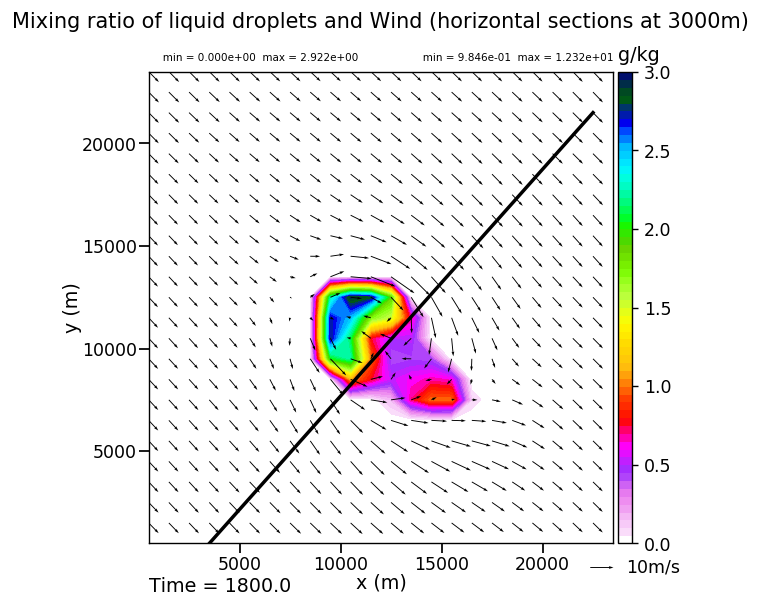

In [22]:
LnameFiles = ['KWRAI.1.SEG01.004.nc','KWRAI.1.SEG01.004dia.nc' ]

Dvar_input = {
'f1':['ZS', 'UT','VT', 'WT','THT',
      'ni_u','nj_u','level','ZTOP', 'ni','nj','level_w','time',
      'INPRR','ACPRR','PABST','RCT','RVT','RRT','LSTHM'],
'f2':['ALT_CLOUD', 'ALT_U', 'ALT_V', 'ni','nj']}

#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path)

Panel1 = PanelPlot(1,1, [5,5],'', titlepad=25, minmaxpad=1.04, timepad=-0.07, colorbarpad=0.01,colorbaraspect=35,
                   minmaxTextSize=6, lateralminmaxpad=1)

fig1 = Panel1.psectionH(lon=[Dvar['f2']['ni']], lat=[Dvar['f2']['nj']], Lvar=[Dvar['f2']['ALT_CLOUD']], Llevel=[0], 
                        Lxlab=['x (m)'], Lylab=['y (m)'], Ltitle=['Mixing ratio of liquid droplets'],
                        Lminval= [0], Lmaxval=[3.0], Lstep=[0.05], Lstepticks=[0.5], Lcolormap=['gist_ncar_r'], 
                        Lcbarlabel=['g/kg'], Ltime=[Dvar['f1']['time']], LaddWhite_cm=[True])
# Wind vectors
fig2 = Panel1.pvector(Lxx=[Dvar['f2']['ni']],Lyy=[Dvar['f2']['nj']], Lvar1=[Dvar['f2']['ALT_U']], Lvar2=[Dvar['f2']['ALT_V']], Lcarte=[500,23500,500,23500], Llevel=[0], 
                      Lxlab=['x (m)'], Lylab=['y (m)'], Ltitle=['Wind (horizontal sections at 3000m)'], Lwidth=[0.002], Larrowstep=[1], 
                      Lcolor=['black'], Llegendval=[10], Llegendlabel=['m/s'], Lid_overlap=[0], ax=fig1.axes, Lscale=[200])

#  Oblique projection
i_beg, j_beg = (3,0)
i_end, j_end = (22,21)
#  Black line
Panel1.addLine(fig2.axes[0],[Dvar['f1']['ni'][i_beg],Dvar['f1']['nj'][j_beg]],[Dvar['f1']['ni'][i_end],Dvar['f1']['nj'][j_end]],'black',2)


The oblique section is defined by 2 points of coordinates (i_beg,j_beg) and (i_end,j_end)

Then, the variables are projected using the function oblique_proj from misc_functions.py

In [ ]:
def oblique_proj(var, ni, nj, lvl, i_beg, j_beg, i_end, j_end):
    """Compute an oblique projection of a variable w.r.t. its axes
    
    Parameters
    ----------
    var : array 3D or 2D
        the variable to project (e.g. THT, ZS)
    
    ni : array 1D
        1D x-axis of the 3D dimension
    
    nj : array 1D
        1D y-axis of the 3D dimension
    
    level : array 1D
        1D z-axe of the 3D dimension
    
    i_beg, j_beg : int
        coordinate of the begin point of the new axe
    
    i_end, j_end : int
        coordinate of the end point of the new axe       
    
     Returns
     -------
    angle_proj : float
        the angle (radian) of the new axe w.r.t the x/ni axes (West-East)
         
    out_var : array 2D or 1D
        a 2D (z,m) or 1D (m) variable projected on the oblique axe
    
    axe_m : array 1D
        a 1D m new axe (distance from the beggining point)
    
    """

In [29]:
from misc_functions import oblique_proj
import math
angle_sec1, RVT_sec1, axe_m1 = oblique_proj(Dvar['f1']['RVT'], Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                            Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)

In [30]:
 i_beg, j_beg, i_end, j_end 

(3, 0, 22, 21)

In [31]:
angle_sec1*180/math.pi

47.86240522611175

In [33]:
Dvar['f1']['ni']

array([  500.,  1500.,  2500.,  3500.,  4500.,  5500.,  6500.,  7500.,
        8500.,  9500., 10500., 11500., 12500., 13500., 14500., 15500.,
       16500., 17500., 18500., 19500., 20500., 21500., 22500., 23500.])

In [34]:
axe_m1

array([    0.        ,  1011.41444704,  2022.82889407,  3034.24334111,
        4045.65778814,  5057.07223518,  6068.48668222,  7079.90112925,
        8091.31557629,  9102.73002333, 10114.14447036, 11125.5589174 ,
       12136.97336443, 13148.38781147, 14159.80225851, 15171.21670554,
       16182.63115258, 17194.04559961, 18205.46004665, 19216.87449369,
       20228.28894072, 21239.70338776, 22251.1178348 , 23262.53228183,
       24273.94672887, 25285.3611759 , 26296.77562294, 27308.19006998,
       28319.60451701])

To project the horizontal-wind vector on the oblique axis, use the function windvec_verti_proj which computes 
projected_wind = u*cos(angle) + v*sin(angle)

In [36]:
def windvec_verti_proj(u, v, level, angle):
    """Compute the projected horizontal wind vector on an axis with a given angle w.r.t. the x/ni axes (West-East)
    
    Parameters
    ----------
    u : array 3D
        U-wind component
    
    v : array 3D
        V-wind component

    level : array 1D
        level dimension array
        
    angle : float
        angle (radian) of the new axe w.r.t the x/ni axes (West-East). angle = 0 for (z,x) sections, angle=pi/2 for (z,y) sections
    
    Returns
    -------
    
    projected_wind : array 3D
        a 3D wind component projected on the axe to be used with Panel_Plot.pvector as Lvar1
    """ 

Water vapor mixing ratio   min = 9.309265839687695e-08  max = 14.027560879013642
Liquid cloud mxing ratio   min = 0.0  max = 2.7079337798854124
Potential temperature anomaly   min = -3.1402889849565128  max = 5.1620337137513435
Vertical velocity   min = -5.153228358091735  max = 17.876526869841406
Wind   min = 0.21545434200365415  max = 36.281184566057135
precipitation   min = 0.0  max = 3.1566808518605995


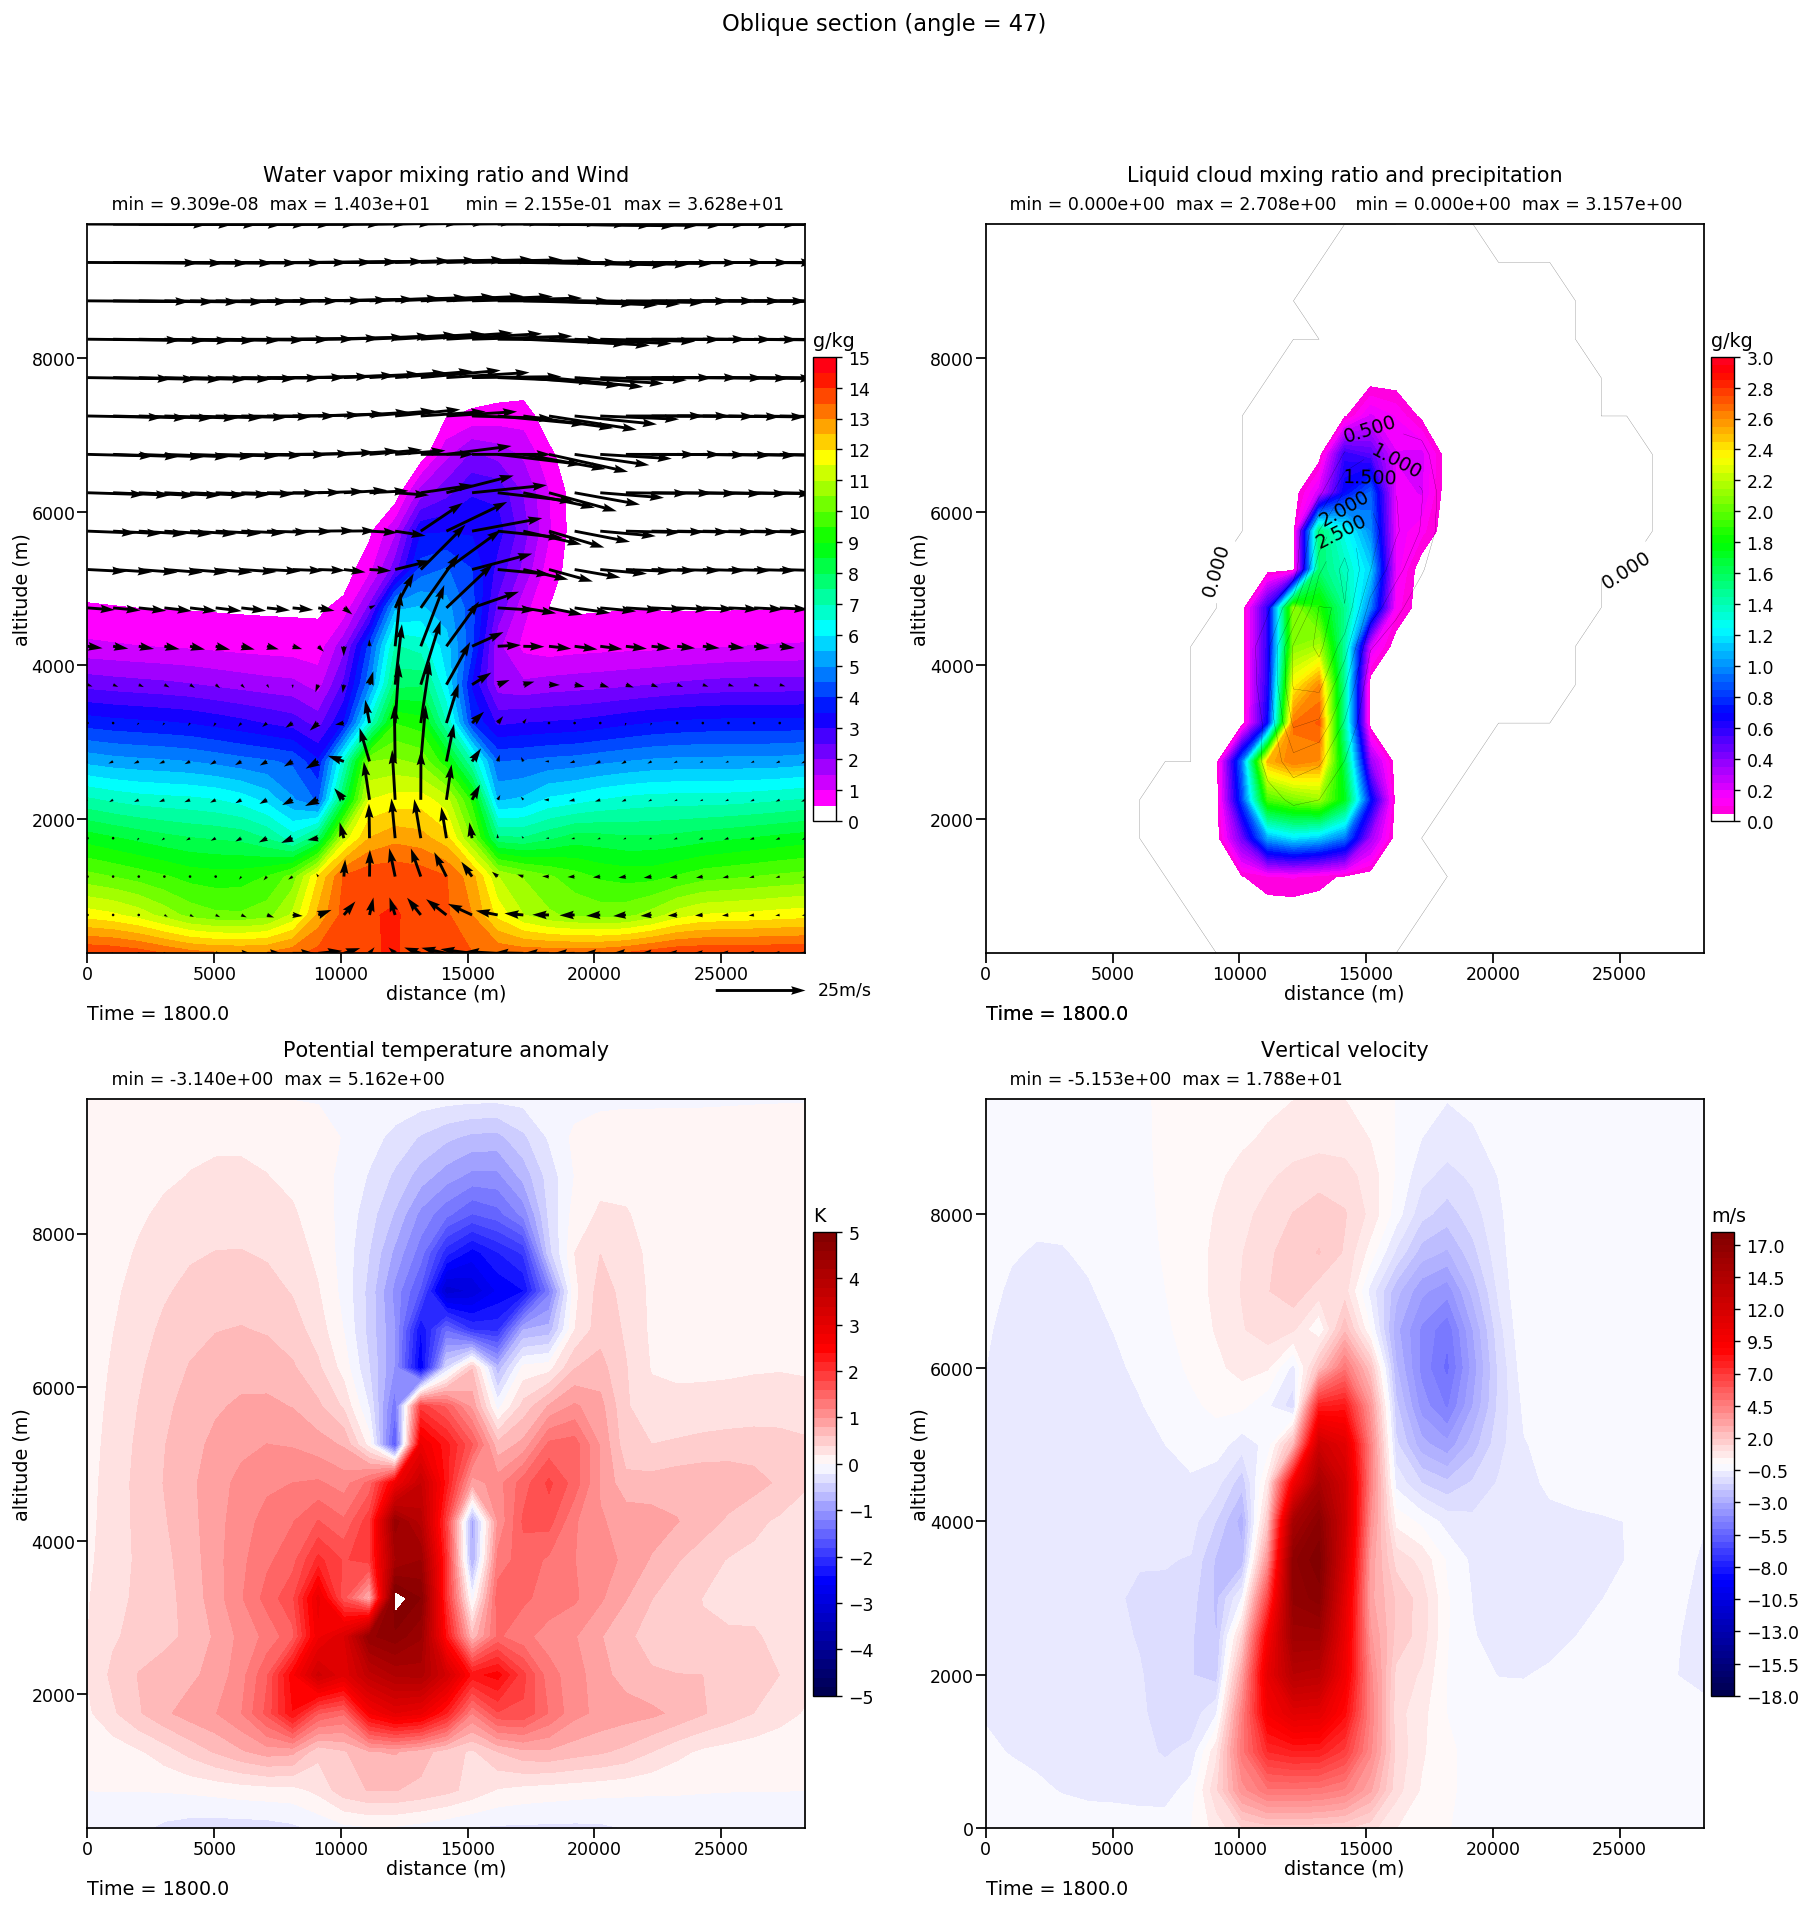

In [39]:
from misc_functions import *

Panel2 = PanelPlot(2,2, [17,17],'Oblique section (angle = 47)', titlepad=25, minmaxpad=1.04, timepad=-0.07, colorbarpad=0.01, lateralminmaxpad=0.97)

Dvar['f1']['THT-LSTHM'] = Dvar['f1']['THT'] - Dvar['f1']['LSTHM']

tomass = mean_operator()
Dvar['f1']['UM'] = tomass.MXM(Dvar['f1']['UT'])
Dvar['f1']['VM'] = tomass.MYM(Dvar['f1']['VT'])
Dvar['f1']['WM'] = tomass.MZM(Dvar['f1']['WT'])

angle_sec1, RVT_sec1, axe_m1    = oblique_proj(Dvar['f1']['RVT'], Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                               Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)
angle_sec1, WIND_sec1, axe_m1   = oblique_proj(WIND_proj, Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                               Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)
angle_sec1, WT_sec1, axe_m1     = oblique_proj(Dvar['f1']['WM'], Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                               Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)
angle_sec1, RCT_sec1, axe_m1    = oblique_proj(Dvar['f1']['RCT'], Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                               Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)
angle_sec1, RRT_sec1, axe_m1    = oblique_proj(Dvar['f1']['RRT'], Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                               Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)
angle_sec1, anoTHT_sec1, axe_m1 = oblique_proj(Dvar['f1']['THT-LSTHM'], Dvar['f1']['ni'], Dvar['f1']['nj'], 
                                               Dvar['f1']['level'], i_beg, j_beg, i_end, j_end)
WIND_proj = windvec_verti_proj(Dvar['f1']['UM'], Dvar['f1']['VM'], Dvar['f1']['level'], angle_sec1)

# Iso-contours projected on the oblique vertical section
Lplot = [RVT_sec1, RCT_sec1, anoTHT_sec1, WT_sec1]
LaxeX = [axe_m1]*len(Lplot)
LaxeZ = [Dvar['f1']['level'], Dvar['f1']['level'], Dvar['f1']['level'],Dvar['f1']['level_w']]
Ltitle = ['Water vapor mixing ratio', 'Liquid cloud mxing ratio', 'Potential temperature anomaly', 'Vertical velocity']
Lcbarlabel = ['g/kg','g/kg', 'K', 'm/s']
Lxlab = ['distance (m)']*len(Lplot)
Lylab = ['altitude (m)']*len(Lplot)
Lminval = [0., 0., -5, -18]
Lmaxval = [15, 3.0, 5, 18]
Lstep = [0.5, 0.05, 0.2, 0.5]
Lstepticks = [1, 0.2, 1, 2.5]
Lfacconv = [1000, 1000, 1, 1]
Lcolormap = ['gist_rainbow_r','gist_rainbow_r', 'seismic','seismic']
Ltime = [Dvar['f1']['time']]*len(Lplot)
Lpltype = ['cf']*len(Lplot)
LaddWhite = [True, True, False, False]

fig3 = Panel2.psectionV(Lxx=LaxeX, Lzz=LaxeZ, Lvar=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, 
                                Lstep=Lstep, Lstepticks=Lstepticks, Lcolormap=Lcolormap, Lcbarlabel=Lcbarlabel, Lfacconv=Lfacconv, 
                                Ltime=Ltime, Lpltype=Lpltype, LaddWhite_cm=LaddWhite)
# Draw vectors on 1st figure
Lplot1 = [ WIND_sec1]
Lplot2 = [ WT_sec1]
Ltitle = ['Wind']
Llegendval = [25]
Llegendlabel = ['m/s']*len(Lplot)
Larrowstep = [1]*len(Lplot)
Lwidth = [0.004]*len(Lplot)
Lscale = [200]*len(Lplot)

fig4 = Panel2.pvector(Lxx=LaxeX, Lyy=LaxeZ, Lvar1=Lplot1, Lvar2=Lplot2, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lwidth=Lwidth, Larrowstep=Larrowstep, 
                        Llegendval=Llegendval, Llegendlabel=Llegendlabel, Lid_overlap=[0], ax=fig3.axes, Lscale=Lscale)

# Draw iso-line on 2nd figure
Lplot = [RRT_sec1]
LaxeX = [axe_m1]
LaxeZ = [Dvar['f1']['level']]
Ltitle = ['precipitation']
Lcbarlabel = ['g/kg']*len(Lplot)
Lxlab = ['distance (m)']*len(Lplot)
Lylab = ['altitude (m)']*len(Lplot)
Lylim = [(0,10000.1)]*len(Lplot)
Lminval = [0.]
Lmaxval = [3.5]
Lstep = [0.5]
Lstepticks = [0.5]
Lfacconv = [1000]*len(Lplot)
LcolorLine = ['black']*len(Lplot)
Llvl = [0]*len(Lplot)
Ltime = [Dvar['f1']['time']]
Lpltype = ['c']*len(Lplot) # iso-ligne
LaddWhite = [True]*len(Lplot)
Lid_overlap=[2]

fig5 = Panel2.psectionV(Lxx=LaxeX, Lzz=LaxeZ, Lvar=Lplot, Lxlab=Lxlab, Lylab=Lylab, Ltitle=Ltitle, Lminval=Lminval, Lmaxval=Lmaxval, 
                                Lstep=Lstep, Lstepticks=Lstepticks, LcolorLine=LcolorLine, Lcbarlabel=Lcbarlabel, Lfacconv=Lfacconv,
                                Ltime=Ltime, Lpltype=Lpltype, LaddWhite_cm=LaddWhite, ax=fig4.axes,Lid_overlap=Lid_overlap,colorbar=False)

## Histogram

In [ ]:
def pXY_bar(self, Lbins=[], Lvar=[], Lxlab=[], Lylab=[], Ltitle=[], Lcolor=[], Lwidth=[],
                 Llinecolor=[], Llinewidth=[], Lfacconv=[], ax=[], id_overlap=None, Lxlim=[], 
                 Lylim=[], Ltime=[], LaxisColor=[]):
      """
        XY Histogram
        Parameters :
       -->  - Lbins    : List of bins
       -->  - Lvar   : List of the value for each bin
            - Lxlab  : List of x-axis label
            - Lylab  : List of y-axis label
            - Ltitle : List of sub-title
            - Lcolor : List of color (or sequence of colors for each value) of the bars
            - Lwidth     : List of width of the bars
            - Llinecolor  : List of line color of the bar edges
            - Llinewidth  : List of lines thickness of the bar edges
            - Lfacconv   : List of factors for unit conversion of each variables
            - Lxlim  : List of x (min, max) value plotted
            - Lylim  : List of y (min, max) value plotted
            - Ltime  : List of time (validity)
            - ax         : List of fig.axes for ploting multiple different types of plots in a subplot panel
            - Lid_overlap: List of number index of plot to overlap current variables
            - LaxisColor : List of colors for multiple x-axis overlap
      """

### Example KTEST 009_ICARTT

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Reading file f1
/home/rodierq/TP_PYTHON/ICART.1.SEG01.001dg.nc
5
6


4

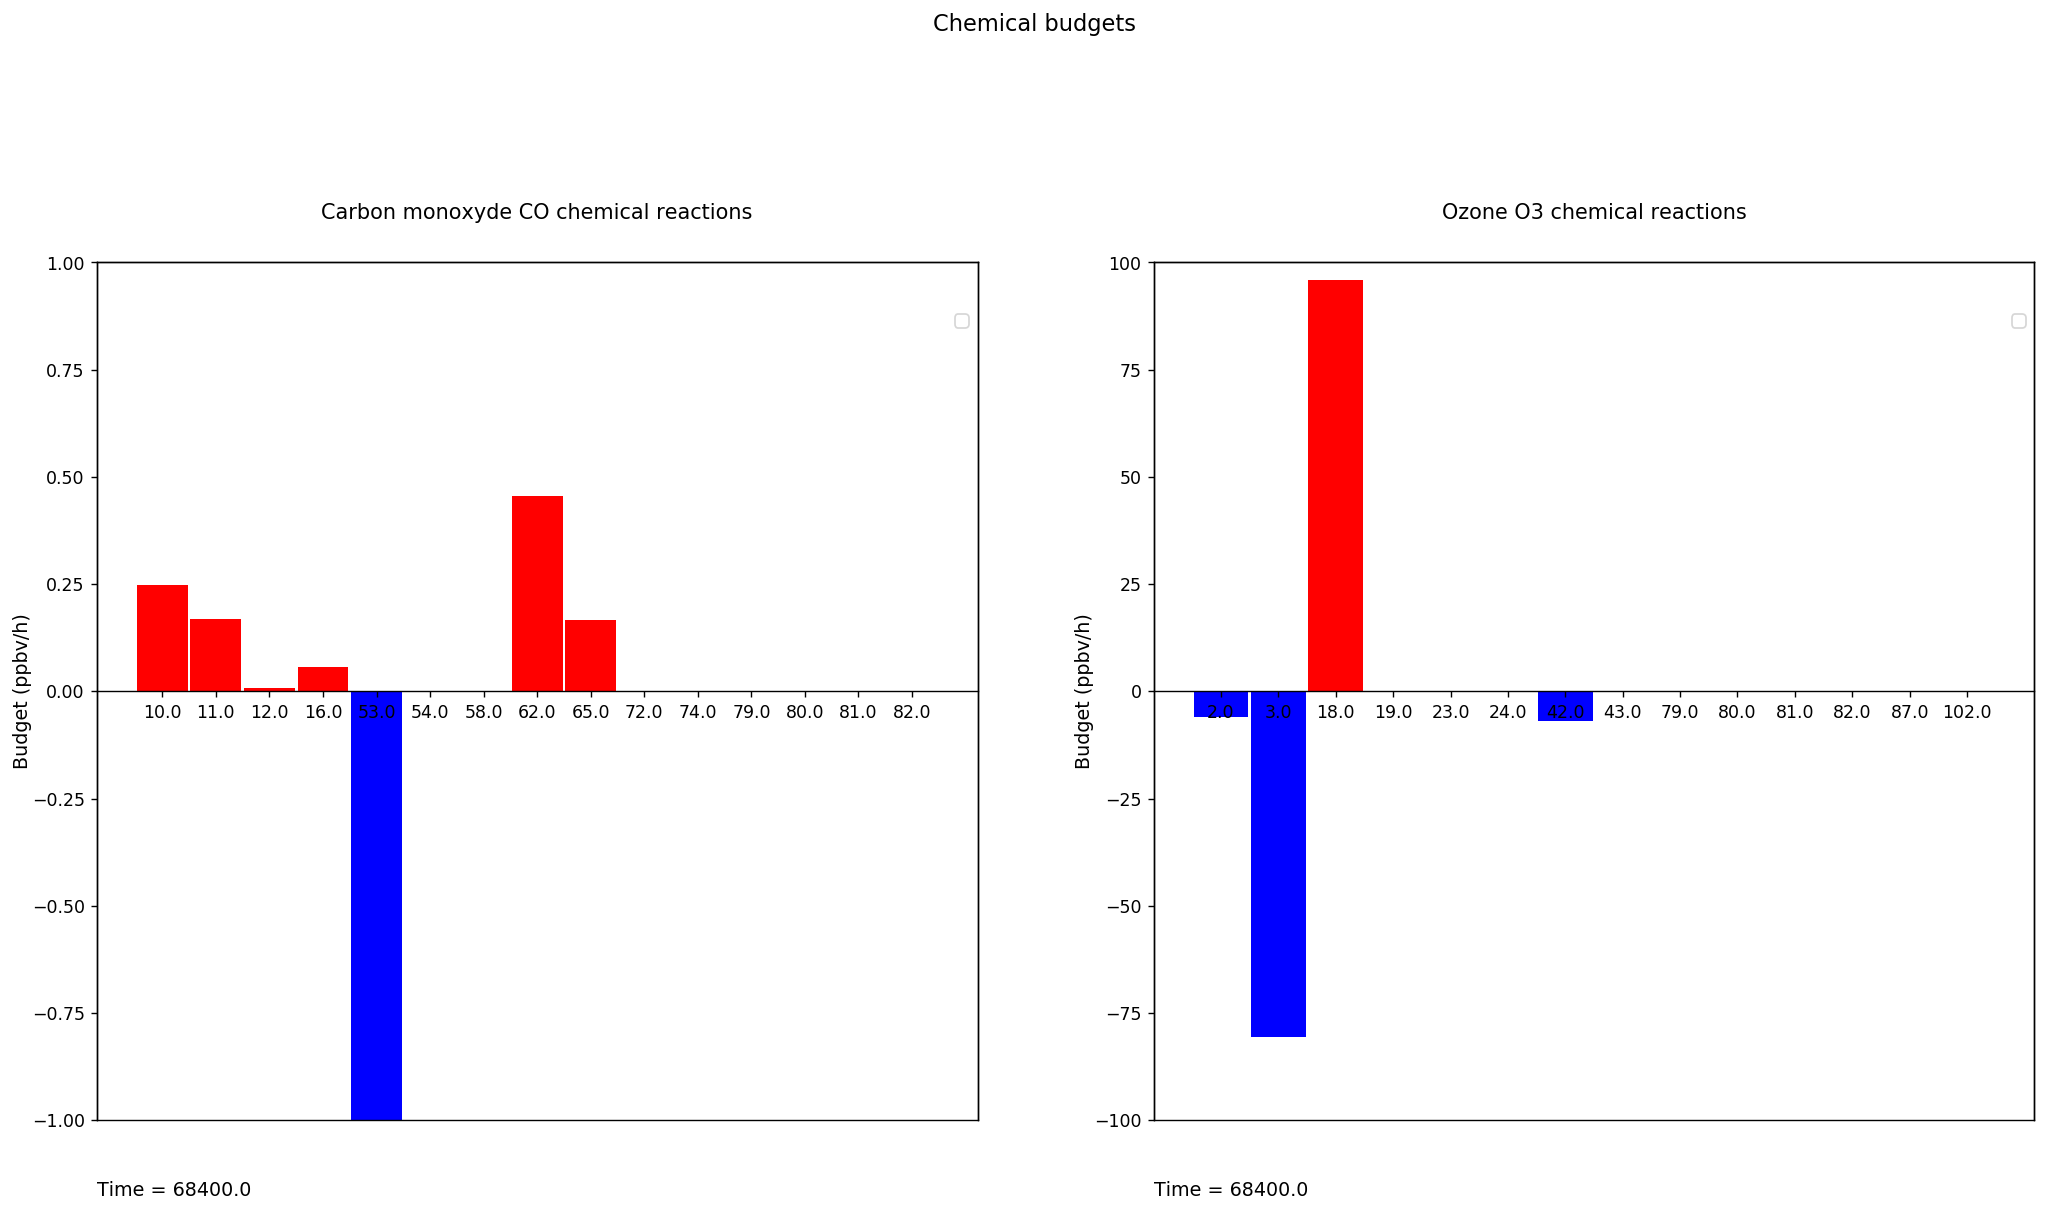

In [42]:
LnameFiles = ['ICART.1.SEG01.001dg.nc']

Dvar_input = {
'f1':['MRC','COT','O3T','O3_PROD','O3_LOSS','CO_PROD','CO_LOSS','level','ZTOP', 'longitude','latitude','level_w','time',
      'CO_BUDGET','O3_BUDGET','O3_CHREACLIST','CO_CHREACLIST']
}
#  Read the variables in the files
Dvar = {}
Dvar = read_netcdf(LnameFiles, Dvar_input, path=path)

Dvar['f1']['CO_BUDGET_mean'] = np.mean(Dvar['f1']['CO_BUDGET'][:,13,:,:],axis=(1,2))  #  {x,y} Average on height = 1150m
Dvar['f1']['O3_BUDGET_mean'] = np.mean(Dvar['f1']['O3_BUDGET'][:,13,:,:],axis=(1,2))  #  {x,y} Average on height = 1150m

Panel3 = PanelPlot(2,2, [20,20],'Chemical budgets', titlepad=25, minmaxpad=1.04, timepad=-0.07, colorbarpad=0.01, colorbaraspect=40, labelcolorbarpad = 13)

Lplot = [Dvar['f1']['CO_BUDGET_mean'], Dvar['f1']['O3_BUDGET_mean']]
Lbins = [Dvar['f1']['CO_CHREACLIST'], Dvar['f1']['O3_CHREACLIST']]
Ltitle = ['Carbon monoxyde CO chemical reactions', 'Ozone O3 chemical reactions']
Lylab = ['Budget (ppbv/h)']*len(Lplot)
Ltime = [Dvar['f1']['time'], Dvar['f1']['time']]
Lylim = [(-1,1), (-100, 100)]
Lfacconv = [1E9*3600]*len(Lplot)
Lwidth = [0.95]*len(Lplot)

Lcolors=[]
for var in Lplot:
    cc=['']*len(var)
    for n,val in enumerate(var):
        if val<0:
            cc[n]='blue'
        elif val>=0:
            cc[n]='red'
    Lcolors.append(cc)

fig3 = Panel3.pXY_bar(Lbins=Lbins, Lvar=Lplot, Lylim=Lylim, Lfacconv=Lfacconv, Ltitle=Ltitle, Lylab=Lylab, Lcolor=Lcolors, Lwidth=Lwidth, Ltime=Ltime)

#  Handle a new axis at y=0 for each graphs
for i,var in enumerate(Lplot):
    ax2 = fig3.axes[i].twinx() #  Clone the existing axis
    ax2_x = ax2.get_xaxis()
    ax2_x.set_label('Chemical reactions')
    ax2_y = ax2.get_yaxis() #  Get the new Y axe and hide it
    ax2_y.set_visible(False)
    fig3.axes[i].spines['bottom'].set_position('center') #  Move the original axis to the center

Panel3.save_graph(3,fig3)

## Streamlines

Setting is hard. No KTEST provided (to be improved)

In [ ]:
def pstreamline(self, Lxx=[], Lyy=[], Lvar1=[], Lvar2=[], Lcarte=[], Llevel=[], Lxlab=[], Lylab=[], Llinewidth=[], Ldensity=[],
                Ltitle=[], Lcolor=[], Lproj=[], Lfacconv=[], ax=[], coastLines=True, Lid_overlap=[], Ltime=[],
                Lylim=[], Lxlim=[]):
      """
        Wind stream lines
        Parameters :
            - Lxx    : List of x or y coordinate variable (lat or ni or nm)
            - Lyy    : List of y coordinates variable (lon or level)
            - Lvar1   : List of wind-component along x/y or oblic axis (3D for hor. section, 2D for vertical section)
            - Lvar2   : List of wind-component along y-axis : v-component for horizontal section / w-component for vertical section
            - Lcarte : Zooming [lonmin, lonmax, latmin, latmax]
            - Llevel : List of k-level value for the horizontal section plot (ignored if variable is already 2D)
            - Lxlab  : List of x-axis label
            - Lylab  : List of y-axis label
            - Lxlim  : List of x (min, max) value plotted
            - Lylim  : List of y (min, max) value plotted
            - Ltitle : List of sub-titles
            - Ltime  : List of time (validity)
            - Llinewidth : List of lines thickness
        --> - Ldensity   : List of density that control the closeness of streamlines
            - Lcolor : List of colors for the streamline (default: black)
            - Lproj      : List of ccrs cartopy projection
            - Lfacconv   : List of factors for unit conversion of each variables
            - coastLines : Boolean to plot coast lines and grid lines
            - ax         : List of fig.axes for ploting multiple different types of plots in a subplot panel
            - Lid_overlap : List of number index of plot to overlap current variables
      """

Please feel free to contribute, add features, type of plots, etc ...
... by pull-request on the git repo https://github.com/QuentinRodier/MNHPy